<a href="https://colab.research.google.com/github/nRknpy/lab-work/blob/main/asl_vit_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViTを用いた手話の認識
事前学習されたVisionTransformerのモデルを，手話のデータセットを用いてファインチューニングする．

# モジュールをインポート

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


## データセットの準備
### ダウンロード
データセットは，ASL Fingerspelling Images（ https://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset ） を用いる．
次のコマンドでダウンロード，解凍を行う．

In [ ]:
!wget http://www.cvssp.org/FingerSpellingKinect2011/fingerspelling5.tar.bz2
!tar -jxvf fingerspelling5.tar.bz2

### Dataset，collate_fnを作成
データセットの中にはRGB画像と深度画像が含まれているが，ここでは前者のみ使う．

pytorchのImageFolderを用いてDatasetを作成するために次のようなディレクトリを作成する．

    asl
    ├── a
        ├── Acolor_0_0002.png
        ├── Acolor_0_0003.png
        ├── Acolor_0_0004.png
        ︙
    ├── b
    ├── c
    ├── d
    ├── e
    ︙

次の関数を用いてDataset用のディレクトリを作成する．

In [ ]:
import os
import shutil

def prepare_asl_dataset(source, destination="asl"):
    cnt = 0
    for person in os.listdir(source):
        for label in os.listdir(source+'/'+person):
            for image in os.listdir(source+'/'+person+'/'+label):
                if image[0]=='c':
                    image_path = source+'/'+person+'/'+label+'/'+image
                    os.makedirs(destination+'/'+label, exist_ok=True)
                    shutil.copyfile(image_path, destination+'/'+label+'/'+person+image)
                    cnt += 1
    print("image count:", cnt)

source_dir = 'asl'
prepare_asl_dataset("dataset5", source_dir)

image count: 65774



モデルの事前学習で行われた画像の前処理の情報をもとに，オリジナルのデータに前処理を施す．前処理のクラスはhuggingfaceからロードできる．

In [ ]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

上で作成したディレクトリから，Datasetを作成する．

In [ ]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

all_dataset = ImageFolder(root=source_dir)

label2id = all_dataset.class_to_idx
id2label = {label:id for id,label in label2id.items()}
label2id

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'k': 9,
 'l': 10,
 'm': 11,
 'n': 12,
 'o': 13,
 'p': 14,
 'q': 15,
 'r': 16,
 's': 17,
 't': 18,
 'u': 19,
 'v': 20,
 'w': 21,
 'x': 22,
 'y': 23}

### 前処理を定義
データに対して次のような前処理を施す．torchvisionのtransformを用いて行う．

1.   224x224にリサイズ
2.   事前学習データの平均及び分散を用いて画像を正規化

訓練用データセットには，加えてランダムな左右反転を施す（左右両方の手を学習させるため）．

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(tuple(feature_extractor.size.values())),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(tuple(feature_extractor.size.values())),
            CenterCrop(tuple(feature_extractor.size.values())),
            ToTensor(),
            normalize,
        ]
    )

In [ ]:
from torch.utils.data import Dataset

# random_splitを用いてデータセットをtrain,val,testに分割すると別々のtransformを割り当てられないため，
# 自作のSubsetを定義してtransformを後から割り当てる．
class SetTransform(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform
  
  def __getitem__(self, idx):
    img, label = self.dataset[idx]
    if self.transform:
      img = self.transform(img)
    return img, label
  
  def __len__(self):
    return len(self.dataset)

データセットをtrain,validation,test用に分割し，各々にtransformを割り当てる．

ここでは，val,test用のデータをそれぞれ1000個ずつとし，残りを訓練に使う．

In [ ]:
val_size = 1000
test_size = 1000
train_size = len(all_dataset) - val_size - test_size

test_dataset, trainval_dataset = torch.utils.data.random_split(all_dataset, [test_size, train_size + val_size])
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_dataset = SetTransform(train_dataset, _train_transforms)
val_dataset = SetTransform(val_dataset, _val_transforms)
test_dataset = SetTransform(test_dataset, _val_transforms)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))
print('test:', len(test_dataset))

train: 63774
validation: 1000
test: 1000


バッチを`pixel_values`と`labels`をキーに持つ辞書にする，collate_fnを作成する．これは，Trainer内でモデルに入力する際にアンパックするためである．

In [ ]:
def collate_fn(examples):
    imgs, labels = zip(*examples)
    pixel_values = torch.stack(imgs)
    labels = torch.tensor(labels)
    return {"pixel_values": pixel_values, "labels": labels}

挙動確認．バッチが辞書型になって返される．

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## モデルの定義
huggingfaceから，事前学習されたViTのモデルをロードする．

In [ ]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label2id),
                                                  label2id=label2id,
                                                  id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainingArgumentsを設定する．詳細は以下の通り．

* モデルのチェックポイント，パラメータを`asl-vit`ディレクトリに保存
* 1エポックごとにチェックポイントを保存
* 1エポックごとに評価
* 学習率=$2.0×10^{-5}$
* 訓練データのバッチサイズ=10
* valデータのバッチサイズ=4
* 3エポック分訓練を回す
* 重み減衰=0.01
* 学習中に得られたベストなモデルを学習後にロードする


In [ ]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"asl-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


評価基準（ここでは正解率）を定義

In [ ]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Trainerを定義．

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

## 訓練

In [ ]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 63774
  Num Epochs = 3
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 19134
  Number of trainable parameters = 85817112


Epoch,Training Loss,Validation Loss,Accuracy
1,0.377100,0.049065,0.995000
2,0.263100,0.015448,0.998000
3,0.199000,0.012128,0.999000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
Saving model checkpoint to asl-vit/checkpoint-6378
Configuration saved in asl-vit/checkpoint-6378/config.json
Model weights saved in asl-vit/checkpoint-6378/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-6378/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
Saving model checkpoint to asl-vit/checkpoint-12756
Configuration saved in asl-vit/checkpoint-12756/config.json
Model weights saved in asl-vit/checkpoint-12756/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-12756/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 4
Saving model checkpoint to asl-vit/checkpoint-19134
Configuration saved in asl-vit/checkpoint-19134/config.json
Model weights saved in asl-vit/checkpoint-19134/pytorch_model.bin
Image processor saved in asl-vit/checkpoint-19134/preprocessor_config.json


Training completed. Do not forget

TrainOutput(global_step=19134, training_loss=0.41359061871848907, metrics={'train_runtime': 7589.1395, 'train_samples_per_second': 25.21, 'train_steps_per_second': 2.521, 'total_flos': 1.4828845798216139e+19, 'train_loss': 0.41359061871848907, 'epoch': 3.0})

## 評価
ファインチューニングしたモデルの性能を評価する．

テストデータをモデルに入力し，推定ラベルを得る．

In [ ]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 4


テストデータに対する損失，正解率等を計算．

In [ ]:
print(outputs.metrics)

{'test_loss': 0.0051841516979038715, 'test_accuracy': 1.0, 'test_runtime': 15.4155, 'test_samples_per_second': 64.87, 'test_steps_per_second': 16.217}


混同行列を作成．

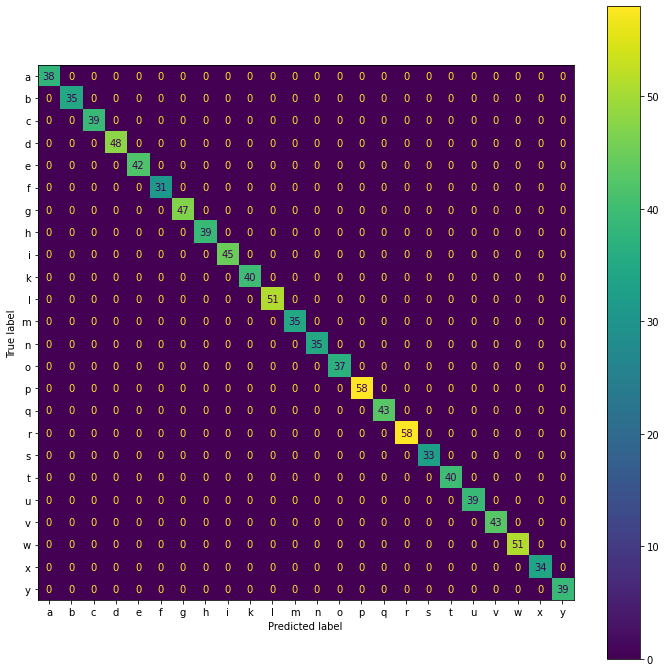

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)